In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2387936.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2334070.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2409937.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2376521.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2363057.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2317630.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2406500.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2343506.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/st

In [2]:
import os
import pandas as pd
import requests
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

dataset_path = '/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv'
image_folder_path = '/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images'

dataset = pd.read_csv(dataset_path)
dataset = dataset.sample(2000, random_state=42).reset_index(drop=True)
print(f"Reduced dataset size: {len(dataset)} rows")
print(dataset.head())

image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(image_files)} images in {image_folder_path}")
print("Sample images:", image_files[:5])

new_image_folder = '/kaggle/working/downloaded_images'
os.makedirs(new_image_folder, exist_ok=True)

Reduced dataset size: 2000 rows
   Image_name                                          Paragraph  train  \
0     2353881  This photograph is of buildings on a crowded s...   True   
1     2373958  The bags are on the conveyor belt at the airpo...  False   
2     2356551  Two giraffes and an antelope are in a large di...   True   
3     2318965  A man walks his dog across a rain soaked stree...   True   
4     2373308  Some zebras stand in a field. Two of them are ...   True   

    test                                                url    val  
0  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
1   True  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
2  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
3  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
4  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
Found 19551 images in /kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/st

In [3]:
def download_image(url, filename, output_folder):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            image_path = os.path.join(output_folder, filename)
            with open(image_path, 'wb') as f:
                f.write(response.content)
            Image.open(image_path).convert("RGB")
            return True
        else:
            print(f"Failed to download {url} (status: {response.status_code})")
            return False
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return False

successful_images = []
dataset['image_filename'] = dataset['Image_name'].apply(lambda x: f"{x}.jpg")

for i, row in dataset.iterrows():
    filename = row['image_filename']
    original_path = os.path.join(image_folder_path, filename)
    new_path = os.path.join(new_image_folder, filename)
    
    if os.path.exists(original_path):
        try:
            Image.open(original_path).convert("RGB")
            os.system(f"cp {original_path} {new_path}")
            successful_images.append(filename)
        except Exception as e:
            print(f"Error copying {filename}: {e}")
            url = row['url']
            if download_image(url, filename, new_image_folder):
                successful_images.append(filename)
    else:
        print(f"Image {filename} not found, downloading...")
        url = row['url']
        if download_image(url, filename, new_image_folder):
            successful_images.append(filename)

print(f"Successfully processed {len(successful_images)} images")
dataset = dataset[dataset['image_filename'].isin(successful_images)].reset_index(drop=True)
print(f"Final dataset size after filtering: {len(dataset)} rows")

Successfully processed 2000 images
Final dataset size after filtering: 2000 rows


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
from collections import Counter
import nltk
nltk.download('punkt')

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0 default size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def clean_text(text):
    return text.lower().strip()

dataset['Paragraph'] = dataset['Paragraph'].apply(clean_text)

all_captions = dataset['Paragraph'].tolist()
tokenizer = nltk.word_tokenize
word_counts = Counter()
for caption in all_captions:
    word_counts.update(tokenizer(caption))

vocab = ['<PAD>', '<START>', '<END>', '<UNK>'] + [word for word, count in word_counts.items() if count >= 3]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

def caption_to_sequence(caption):
    tokens = tokenizer(caption)
    seq = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    return [word2idx['<START>']] + seq + [word2idx['<END>']]

class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_filename'])
        try:
            image = Image.open(image_path).convert("RGB")
            caption = row['Paragraph']
            if self.transform:
                image = self.transform(image)
            caption_seq = caption_to_sequence(caption)
            return image, torch.tensor(caption_seq)
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            return None, None

train_data = dataset[dataset['train'] == 1]
val_data = dataset[dataset['val'] == 1]
test_data = dataset[dataset['test'] == 1]

batch_size = 8
train_dataset = ImageCaptionDataset(train_data, new_image_folder, image_transform)
val_dataset = ImageCaptionDataset(val_data, new_image_folder, image_transform)
test_dataset = ImageCaptionDataset(test_data, new_image_folder, image_transform)

def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if len(batch) == 0:
        return None
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=word2idx['<PAD>'])
    return images, captions

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Vocabulary size: 2077


In [5]:
import torch.nn as nn
from torchvision.models import efficientnet_b0

class CNNLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(CNNLSTMModel, self).__init__()
        self.cnn = efficientnet_b0(pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove final classifier layer
        # Freeze CNN initially
        for param in self.cnn.parameters():
            param.requires_grad = False
        self.embed = nn.Embedding(vocab_size, embed_size)
        # EfficientNet-B0 outputs 1280 features
        self.lstm = nn.LSTM(embed_size + 1280, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, images, captions):
        features = self.cnn(images)  # [batch_size, 1280]
        features = features.unsqueeze(1).repeat(1, captions.size(1), 1)  # [batch_size, seq_len, 1280]
        embeddings = self.embed(captions)  # [batch_size, seq_len, embed_size]
        inputs = torch.cat((features, embeddings), dim=2)  # [batch_size, seq_len, 1280 + embed_size]
        outputs, _ = self.lstm(inputs)  # [batch_size, seq_len, hidden_size]
        outputs = self.fc(outputs)  # [batch_size, seq_len, vocab_size]
        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel(vocab_size).to(device)
print("Model loaded on:", device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 111MB/s] 


Model loaded on: cpu


In [6]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
output_dir = '/kaggle/working/checkpoints'
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        if batch is None:
            continue
        images, captions = batch
        images, captions = images.to(device), captions.to(device)
        
        outputs = model(images, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=2)
        mask = captions[:, 1:] != word2idx['<PAD>']
        train_correct += (preds[mask] == captions[:, 1:][mask]).sum().item()
        train_total += mask.sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total if train_total > 0 else 0
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    torch.save(model.state_dict(), os.path.join(output_dir, f'model_epoch_{epoch+1}.pt'))

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            if batch is None:
                continue
            images, captions = batch
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=2)
            mask = captions[:, 1:] != word2idx['<PAD>']
            val_correct += (preds[mask] == captions[:, 1:][mask]).sum().item()
            val_total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step()
    if epoch > 1 and val_losses[-1] > val_losses[-2]:
        print("Early stopping triggered")
        break

Epoch 1 - Training: 100%|██████████| 192/192 [02:05<00:00,  1.53it/s]


Epoch 1, Train Loss: 4.4070, Train Accuracy: 0.2480


Epoch 1 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.49it/s]


Epoch 1, Val Loss: 3.9004, Val Accuracy: 0.2963


Epoch 2 - Training: 100%|██████████| 192/192 [02:09<00:00,  1.49it/s]


Epoch 2, Train Loss: 3.6526, Train Accuracy: 0.3153


Epoch 2 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


Epoch 2, Val Loss: 3.5943, Val Accuracy: 0.3250


Epoch 3 - Training: 100%|██████████| 192/192 [02:08<00:00,  1.50it/s]


Epoch 3, Train Loss: 3.3387, Train Accuracy: 0.3426


Epoch 3 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Epoch 3, Val Loss: 3.4439, Val Accuracy: 0.3420


Epoch 4 - Training: 100%|██████████| 192/192 [02:07<00:00,  1.50it/s]


Epoch 4, Train Loss: 3.1238, Train Accuracy: 0.3629


Epoch 4 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.55it/s]


Epoch 4, Val Loss: 3.3663, Val Accuracy: 0.3482


Epoch 5 - Training: 100%|██████████| 192/192 [02:07<00:00,  1.51it/s]


Epoch 5, Train Loss: 2.9563, Train Accuracy: 0.3792


Epoch 5 - Validation: 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


Epoch 5, Val Loss: 3.2742, Val Accuracy: 0.3581


Epoch 6 - Training: 100%|██████████| 192/192 [02:11<00:00,  1.46it/s]


Epoch 6, Train Loss: 2.8204, Train Accuracy: 0.3920


Epoch 6 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Epoch 6, Val Loss: 3.2601, Val Accuracy: 0.3587


Epoch 7 - Training: 100%|██████████| 192/192 [02:07<00:00,  1.51it/s]


Epoch 7, Train Loss: 2.7130, Train Accuracy: 0.4048


Epoch 7 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.58it/s]


Epoch 7, Val Loss: 3.2299, Val Accuracy: 0.3652


Epoch 8 - Training: 100%|██████████| 192/192 [02:07<00:00,  1.50it/s]


Epoch 8, Train Loss: 2.6142, Train Accuracy: 0.4159


Epoch 8 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Epoch 8, Val Loss: 3.2116, Val Accuracy: 0.3656


Epoch 9 - Training: 100%|██████████| 192/192 [02:06<00:00,  1.52it/s]


Epoch 9, Train Loss: 2.5290, Train Accuracy: 0.4274


Epoch 9 - Validation: 100%|██████████| 31/31 [00:12<00:00,  2.52it/s]


Epoch 9, Val Loss: 3.1777, Val Accuracy: 0.3678


Epoch 10 - Training: 100%|██████████| 192/192 [02:07<00:00,  1.51it/s]


Epoch 10, Train Loss: 2.4573, Train Accuracy: 0.4363


Epoch 10 - Validation: 100%|██████████| 31/31 [00:11<00:00,  2.59it/s]

Epoch 10, Val Loss: 3.2187, Val Accuracy: 0.3659
Early stopping triggered


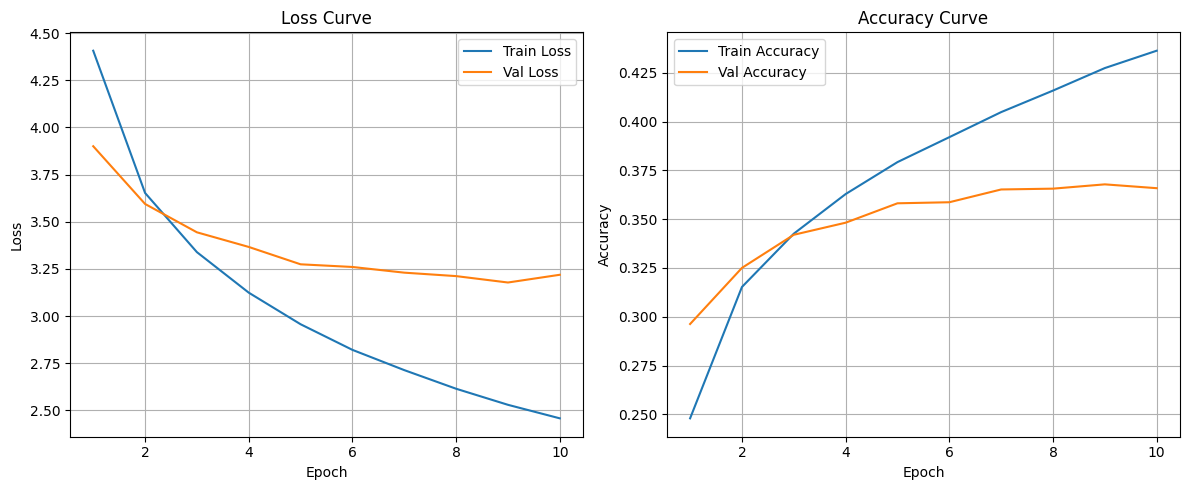

Curves saved to /kaggle/working/loss_accuracy_curves.png


In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/loss_accuracy_curves.png')
plt.show()
print("Curves saved to /kaggle/working/loss_accuracy_curves.png")